In [1]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
from floppity.preprocessing import Normalizer
from sklearn.preprocessing import  StandardScaler
plt.rc('font', size=16)
import torch
from corner import corner
from tqdm import trange
from time import time
import seaborn as sns
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [2]:
def simulator(obs, pars, thread=0):
    def gaussian(x, centers, sigmas, amplitudes):
        """Add multiple Gaussian features.

        Args:
            x (np.ndarray): Input x-axis (e.g., wavelengths).
            centers (list): List of Gaussian centers.
            sigmas (list): List of Gaussian standard deviations.
            amplitudes (list): List of Gaussian amplitudes.

        Returns:
            np.ndarray: Sum of all Gaussian features evaluated at x.
        """
        y = np.ones_like(x)
        for c, s, a in zip(centers, sigmas, amplitudes):
            y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
        return y

    c=pars[:,0:3]
    s=pars[:,3:6]
    a=pars[:,6:9]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Setup retrieval

In [3]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(['obs_RV_1.txt', 'obs_RV_2.txt'])

### Add parameters
R.add_parameter('center1', 1, 5)
R.add_parameter('center2', 4, 8)
R.add_parameter('center3', 8, 12)
R.add_parameter('sigma1', 0.1, 0.7)
R.add_parameter('sigma2', 0.1, 0.7)
R.add_parameter('sigma3', 0.1, 0.7)
R.add_parameter('amplitude1', 0, 1)
R.add_parameter('amplitude2', 0, 1)
R.add_parameter('amplitude3', 0, 1)
R.add_parameter('RV', 0, 10000, post_process=True)
R.add_parameter('offset', -0.1, 0.1, post_process=True)

In [5]:
training_kwargs= dict(
    stop_after_epochs = 5,
    num_atoms = 20,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=4,
    transforms=10,
    blocks=2,
    hidden=32,
    dropout=0.25
)

### Run retrieval

In [7]:
R.run(flow_kwargs=flow_kwargs, resume=False, n_threads=4, training_kwargs=training_kwargs, n_rounds=100, n_samples=10)

Starting training...
Round 1
 Neural network successfully converged after 6 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: 1.7879
        -------------------------
        
Round 2


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7918qdo__j/croot/libtorch_1744403106694/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(


Using SNPE-C with atomic loss
 Neural network successfully converged after 6 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: -3.2175
        -------------------------
        
Round 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -1.8881
        -------------------------
        
Round 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -8.0225
        -------------------------
        
Round 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -1.7917
        -------------------------
        
Round 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -9.7253
        -------------------------
        
Round 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -12.0226
        -------------------------
        
Round 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -12.5131
        -------------------------
        
Round 9


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -12.8991
        -------------------------
        
Round 10


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -11.3641
        -------------------------
        
Round 11


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -16.0355
        -------------------------
        
Round 12


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 12 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -13.1466
        -------------------------
        
Round 13


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 13 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -13.7212
        -------------------------
        
Round 14


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 14 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -15.4248
        -------------------------
        
Round 15


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 15 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -15.8794
        -------------------------
        
Round 16


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 16 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -16.1505
        -------------------------
        
Round 17


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 17 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -15.7726
        -------------------------
        
Round 18


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 18 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -13.2310
        -------------------------
        
Round 19


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
        -------------------------
        ||||| ROUND 19 STATS |||||:
        -------------------------
        Epochs trained: 36
        Best validation performance: -16.6666
        -------------------------
        
Round 20


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 20 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -17.0423
        -------------------------
        
Round 21


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.
        -------------------------
        ||||| ROUND 21 STATS |||||:
        -------------------------
        Epochs trained: 39
        Best validation performance: -19.5373
        -------------------------
        
Round 22


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 22 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -19.0424
        -------------------------
        
Round 23


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 23 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -13.5638
        -------------------------
        
Round 24


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 24 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -19.4625
        -------------------------
        
Round 25


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 25 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -19.7820
        -------------------------
        
Round 26


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 26 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -19.3528
        -------------------------
        
Round 27


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 34 epochs.
        -------------------------
        ||||| ROUND 27 STATS |||||:
        -------------------------
        Epochs trained: 34
        Best validation performance: -19.5667
        -------------------------
        
Round 28


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 28 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -18.9381
        -------------------------
        
Round 29


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 44 epochs.
        -------------------------
        ||||| ROUND 29 STATS |||||:
        -------------------------
        Epochs trained: 44
        Best validation performance: -21.5668
        -------------------------
        
Round 30


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 30 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -18.2702
        -------------------------
        
Round 31


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 31 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -18.9105
        -------------------------
        
Round 32


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 32 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -20.4881
        -------------------------
        
Round 33


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 33 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -17.1339
        -------------------------
        
Round 34


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 34 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: -13.8875
        -------------------------
        
Round 35


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 35 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -20.5800
        -------------------------
        
Round 36


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 36 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -18.8377
        -------------------------
        
Round 37


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 37 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: -16.4486
        -------------------------
        
Round 38


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 38 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -20.1663
        -------------------------
        
Round 39


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
        -------------------------
        ||||| ROUND 39 STATS |||||:
        -------------------------
        Epochs trained: 38
        Best validation performance: -20.3627
        -------------------------
        
Round 40


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 40 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -19.4818
        -------------------------
        
Round 41


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
        -------------------------
        ||||| ROUND 41 STATS |||||:
        -------------------------
        Epochs trained: 40
        Best validation performance: -22.1886
        -------------------------
        
Round 42


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
        -------------------------
        ||||| ROUND 42 STATS |||||:
        -------------------------
        Epochs trained: 40
        Best validation performance: -22.7850
        -------------------------
        
Round 43


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.
        -------------------------
        ||||| ROUND 43 STATS |||||:
        -------------------------
        Epochs trained: 53
        Best validation performance: -22.9112
        -------------------------
        
Round 44


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.
        -------------------------
        ||||| ROUND 44 STATS |||||:
        -------------------------
        Epochs trained: 51
        Best validation performance: -23.7855
        -------------------------
        
Round 45


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 45 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -23.6683
        -------------------------
        
Round 46


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 46 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -23.9652
        -------------------------
        
Round 47


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 47 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -25.0821
        -------------------------
        
Round 48


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 48 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -24.8099
        -------------------------
        
Round 49


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 49 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -26.7914
        -------------------------
        
Round 50


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 50 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -25.0966
        -------------------------
        
Round 51


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.
        -------------------------
        ||||| ROUND 51 STATS |||||:
        -------------------------
        Epochs trained: 39
        Best validation performance: -26.4842
        -------------------------
        
Round 52


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 52 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -27.0349
        -------------------------
        
Round 53


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 53 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -26.0850
        -------------------------
        
Round 54


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 54 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -26.9638
        -------------------------
        
Round 55


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 55 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -26.9893
        -------------------------
        
Round 56


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 56 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -25.4383
        -------------------------
        
Round 57


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 57 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -28.6177
        -------------------------
        
Round 58


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 58 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -27.6805
        -------------------------
        
Round 59


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 59 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -28.3730
        -------------------------
        
Round 60


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 60 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -29.3620
        -------------------------
        
Round 61


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 61 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -28.5228
        -------------------------
        
Round 62


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 62 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -29.9614
        -------------------------
        
Round 63


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 63 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -29.9158
        -------------------------
        
Round 64


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 64 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -28.3464
        -------------------------
        
Round 65


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 65 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -28.9234
        -------------------------
        
Round 66


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 31 epochs.
        -------------------------
        ||||| ROUND 66 STATS |||||:
        -------------------------
        Epochs trained: 31
        Best validation performance: -29.1001
        -------------------------
        
Round 67


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 67 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -28.9813
        -------------------------
        
Round 68


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 68 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -30.9052
        -------------------------
        
Round 69


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.
        -------------------------
        ||||| ROUND 69 STATS |||||:
        -------------------------
        Epochs trained: 26
        Best validation performance: -30.4484
        -------------------------
        
Round 70


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 70 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -29.8247
        -------------------------
        
Round 71


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 71 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -31.4662
        -------------------------
        
Round 72


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 25 epochs.
        -------------------------
        ||||| ROUND 72 STATS |||||:
        -------------------------
        Epochs trained: 25
        Best validation performance: -31.8693
        -------------------------
        
Round 73


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.
        -------------------------
        ||||| ROUND 73 STATS |||||:
        -------------------------
        Epochs trained: 33
        Best validation performance: -31.5167
        -------------------------
        
Round 74


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 74 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -32.3823
        -------------------------
        
Round 75


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 75 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -32.3233
        -------------------------
        
Round 76


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 76 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: -29.3206
        -------------------------
        
Round 77


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 77 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -31.8525
        -------------------------
        
Round 78


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 78 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -30.5353
        -------------------------
        
Round 79


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 79 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -32.2309
        -------------------------
        
Round 80


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 80 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -33.1654
        -------------------------
        
Round 81


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
        -------------------------
        ||||| ROUND 81 STATS |||||:
        -------------------------
        Epochs trained: 27
        Best validation performance: -33.3000
        -------------------------
        
Round 82


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
        -------------------------
        ||||| ROUND 82 STATS |||||:
        -------------------------
        Epochs trained: 35
        Best validation performance: -34.0031
        -------------------------
        
Round 83


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
        -------------------------
        ||||| ROUND 83 STATS |||||:
        -------------------------
        Epochs trained: 32
        Best validation performance: -33.3155
        -------------------------
        
Round 84


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 30 epochs.
        -------------------------
        ||||| ROUND 84 STATS |||||:
        -------------------------
        Epochs trained: 30
        Best validation performance: -34.4970
        -------------------------
        
Round 85


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 85 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -33.3770
        -------------------------
        
Round 86


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 21 epochs.
        -------------------------
        ||||| ROUND 86 STATS |||||:
        -------------------------
        Epochs trained: 21
        Best validation performance: -32.9600
        -------------------------
        
Round 87


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.
        -------------------------
        ||||| ROUND 87 STATS |||||:
        -------------------------
        Epochs trained: 23
        Best validation performance: -32.9025
        -------------------------
        
Round 88


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
        -------------------------
        ||||| ROUND 88 STATS |||||:
        -------------------------
        Epochs trained: 36
        Best validation performance: -35.8372
        -------------------------
        
Round 89


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.
        -------------------------
        ||||| ROUND 89 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -32.9961
        -------------------------
        
Round 90


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.
        -------------------------
        ||||| ROUND 90 STATS |||||:
        -------------------------
        Epochs trained: 29
        Best validation performance: -34.9300
        -------------------------
        
Round 91


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 91 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -31.2004
        -------------------------
        
Round 92


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 92 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -33.7168
        -------------------------
        
Round 93


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 93 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -34.7440
        -------------------------
        
Round 94


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 19 epochs.
        -------------------------
        ||||| ROUND 94 STATS |||||:
        -------------------------
        Epochs trained: 19
        Best validation performance: -34.2017
        -------------------------
        
Round 95


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 17 epochs.
        -------------------------
        ||||| ROUND 95 STATS |||||:
        -------------------------
        Epochs trained: 17
        Best validation performance: -34.3398
        -------------------------
        
Round 96


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 96 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -33.2663
        -------------------------
        
Round 97


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 97 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -34.3904
        -------------------------
        
Round 98


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 98 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -35.1024
        -------------------------
        
Round 99


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 18 epochs.
        -------------------------
        ||||| ROUND 99 STATS |||||:
        -------------------------
        Epochs trained: 18
        Best validation performance: -32.8300
        -------------------------
        
Round 100


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 100 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -35.1572
        -------------------------
        


### Save retrieval object

In [8]:
R.save('r.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [3]:
R=Retrieval.load('r.pkl')

### Resume training

In [10]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=4, training_kwargs=training_kwargs, n_rounds=1, n_samples=100)

Resuming training...
Round 1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.
        -------------------------
        ||||| ROUND 101 STATS |||||:
        -------------------------
        Epochs trained: 24
        Best validation performance: -35.7241
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

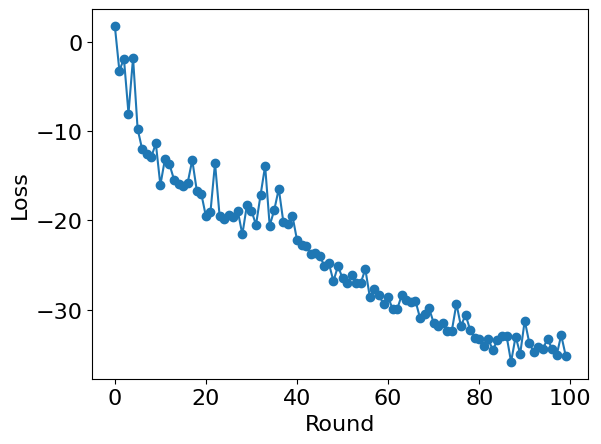

In [4]:
plt.plot(R.inference._summary['best_validation_loss'], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

In [5]:
from floppity.plot_utils import plot_corner

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

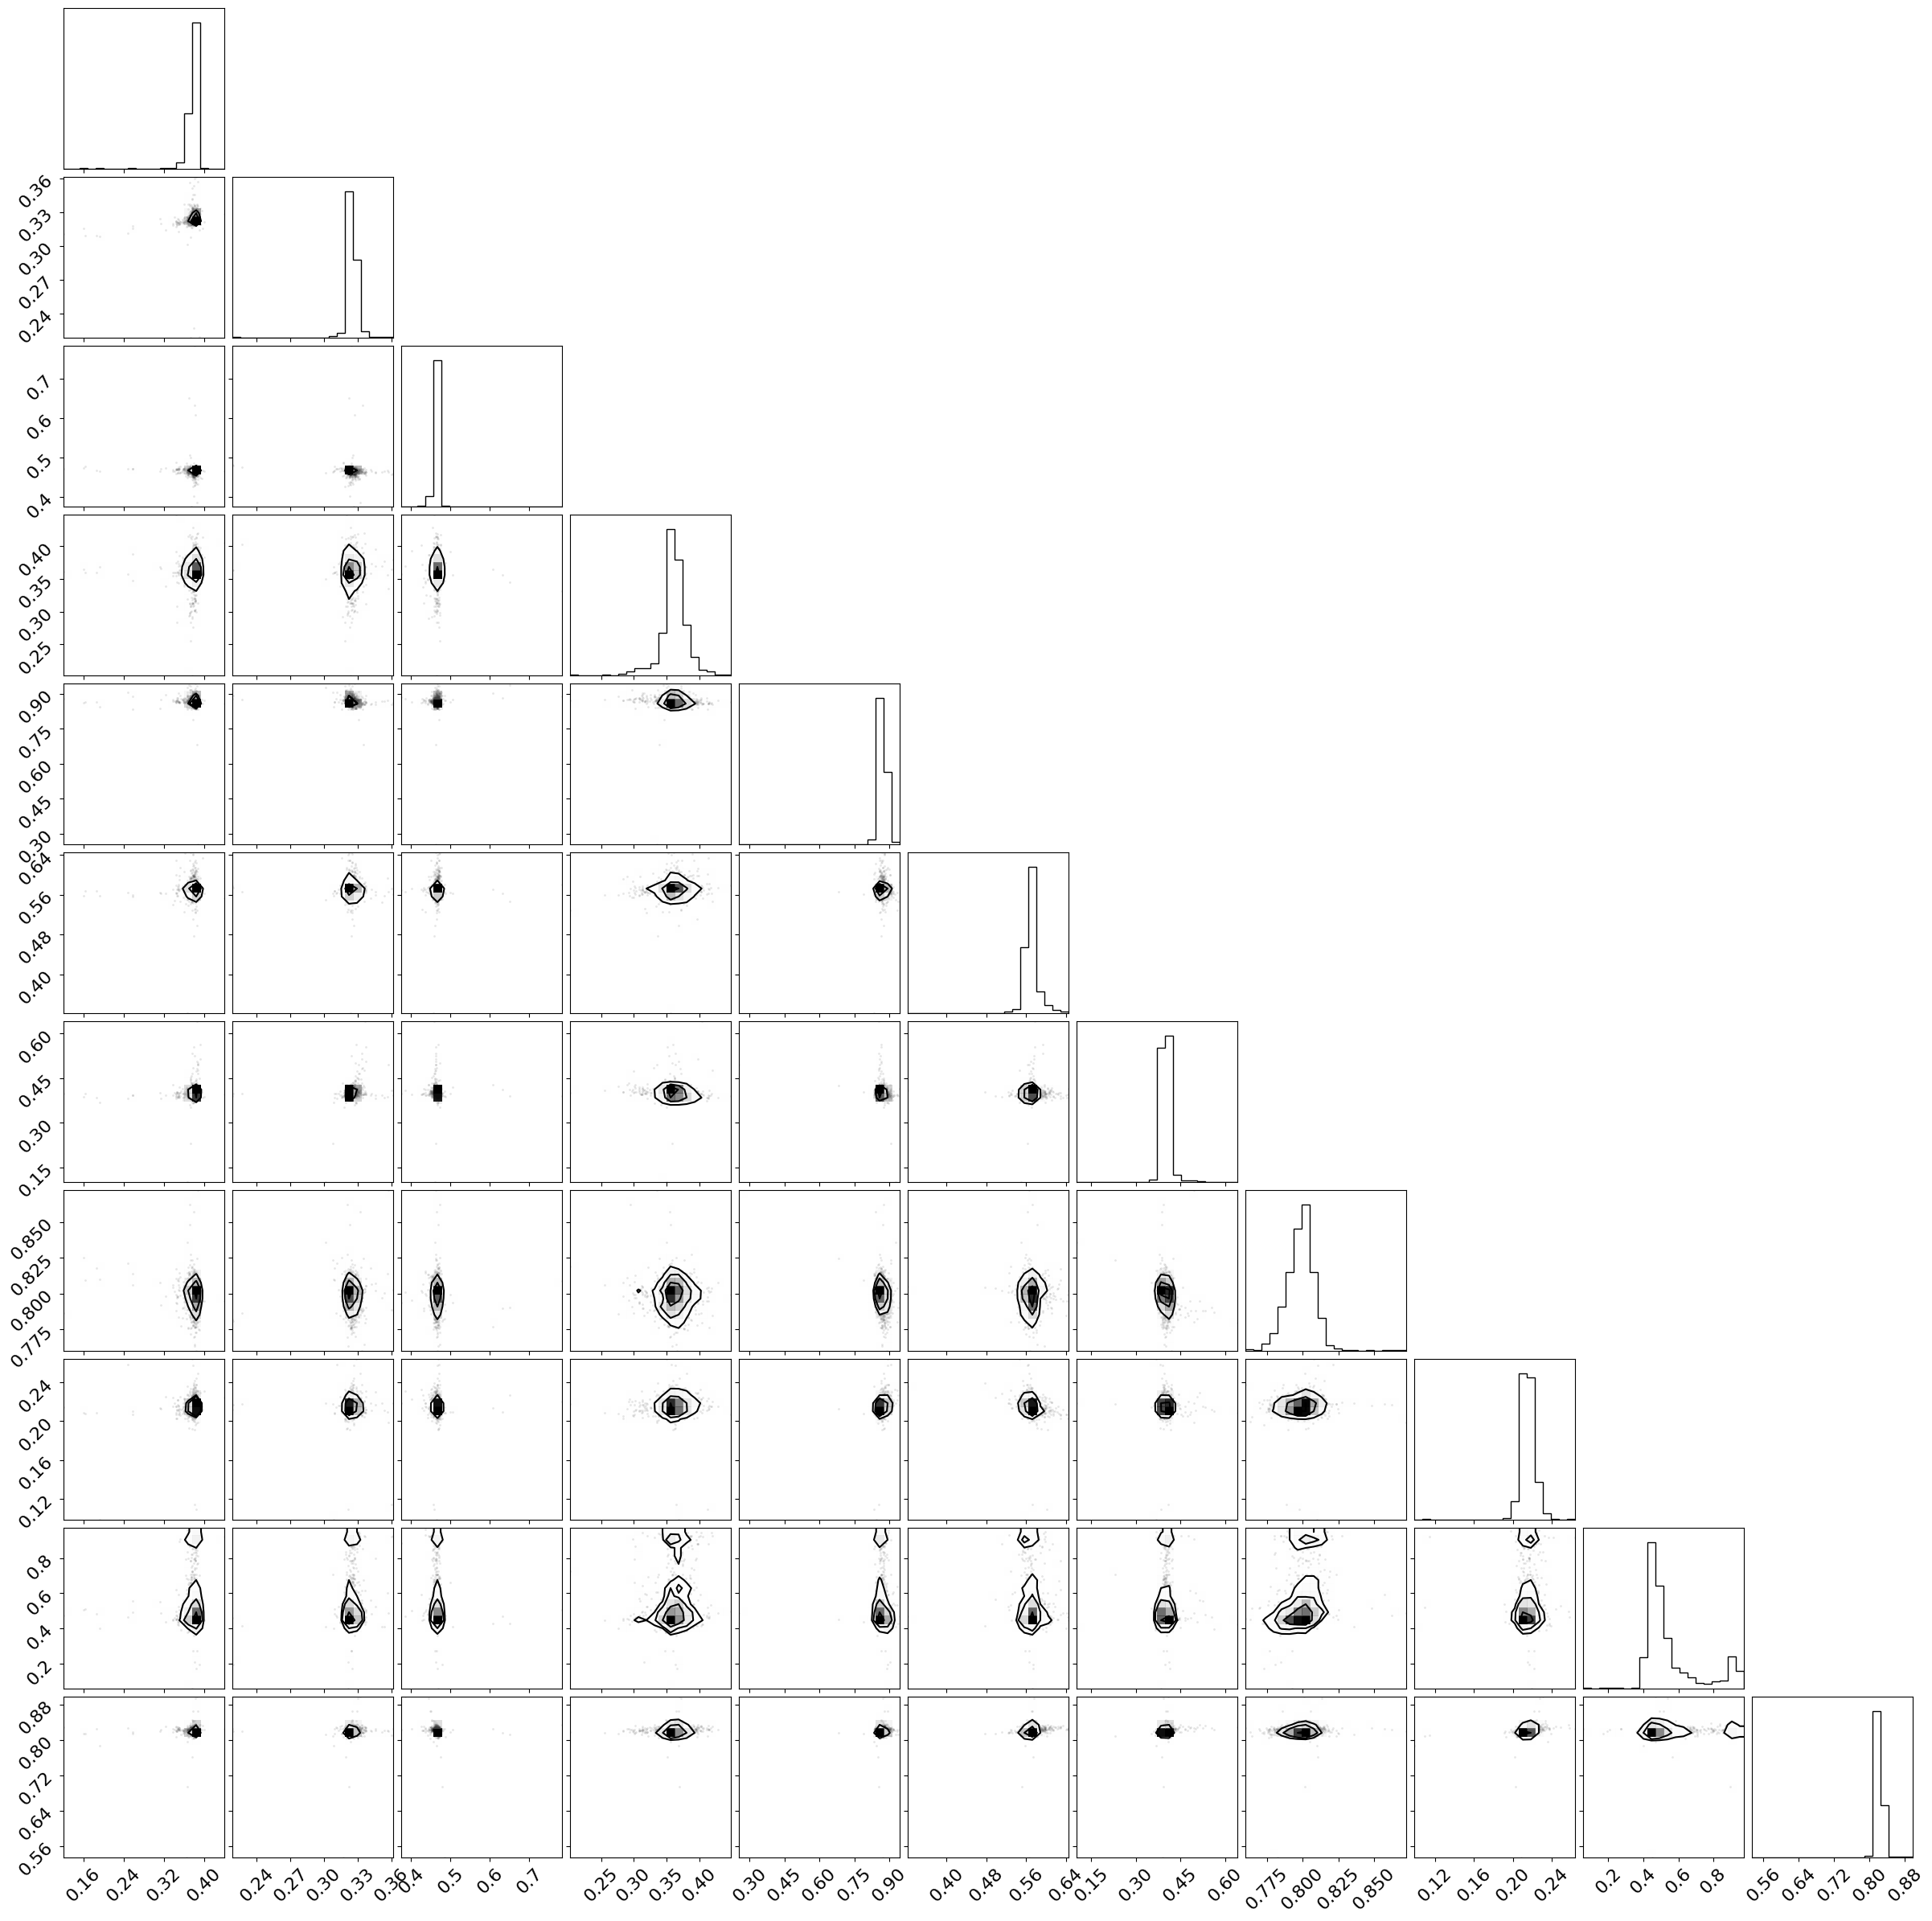

In [ ]:
CORNER_KWARGS=
corner_plot=plot_corner(R.proposals[-1], 1000)

## Posterior diagnostics

### Posterior predictive check

100%|██████████| 100000/100000 [02:15<00:00, 736.63it/s]


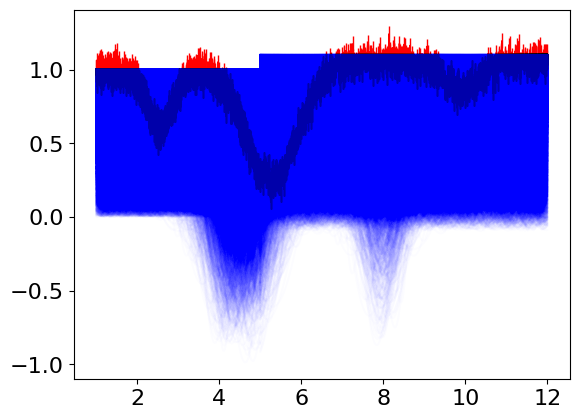

In [ ]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=R.obs[key][:,2], c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

In [ ]:
def compute_moments(distribution, num_repeats=10, sample_size=10000):
    """
    Computes the first four per-dimension moments of a multivariate PyTorch distribution,
    along with standard errors from repeated sampling.

    Parameters
    ----------
    distribution : torch.distributions.Distribution
        A PyTorch distribution (must return multivariate samples).
    num_repeats : int
        Number of repetitions to estimate standard error.
    sample_size : int
        Number of samples per repetition.

    Returns
    -------
    moments : dict of numpy arrays
        Dictionary with shape-[D] arrays for each moment/statistic, where D is the number of dimensions:
        - 'mean', 'variance', 'skewness', 'kurtosis'
        - 'mean_error', 'variance_error', 'skewness_error', 'kurtosis_error'
    """
    # Sample once to determine shape
    test_sample = distribution.sample((1,))
    if test_sample.ndim == 1:
        D = test_sample.shape[0]
    else:
        D = test_sample.shape[1]

    # Initialize accumulators
    means = []
    variances = []
    skewnesses = []
    kurtoses = []

    for _ in range(num_repeats):
        samples = distribution.sample((sample_size,))  # [sample_size, D]

        mean = samples.mean(dim=0)
        var = samples.var(dim=0, unbiased=True)
        std = torch.sqrt(var)

        # Standardize
        # centered = (samples - mean) / std
        # skew = (centered ** 3).mean(dim=0)
        # kurt = (centered ** 4).mean(dim=0) - 3  # Excess kurtosis

        means.append(mean.numpy())
        variances.append(var.numpy())
        # skewnesses.append(skew.numpy())
        # kurtoses.append(kurt.numpy())

    # Convert to arrays
    means = np.stack(means)
    variances = np.stack(variances)
    # skewnesses = np.stack(skewnesses)
    # kurtoses = np.stack(kurtoses)

    return {
        'mean': means.mean(axis=0),
        'variance': variances.mean(axis=0),
        # 'skewness': skewnesses.mean(axis=0),
        # 'kurtosis': kurtoses.mean(axis=0),
        'mean_error': means.std(axis=0, ddof=1),
        'variance_error': variances.std(axis=0, ddof=1),
        # 'skewness_error': skewnesses.std(axis=0, ddof=1),
        # 'kurtosis_error': kurtoses.std(axis=0, ddof=1),
    }


In [ ]:
def plot_moment_evolution(distributions, end, compute_moments_fn, R=None, num_repeats=10, sample_size=10000):
    """
    Plot the evolution of moments across training rounds for a list of multivariate distributions,
    with shaded error bars and tightly stacked subplots.

    Parameters
    ----------
    distributions : list of torch.distributions.Distribution
        List of proposal distributions (one per training round).
    compute_moments_fn : function
        Function that returns a dict of per-dimension moment arrays and their errors.
    R : optional
        Object with .parameters (e.g. from sbi) to label dimension names.
    """
    n_rounds = len(distributions)
    moments_all = [compute_moments_fn(d, num_repeats, sample_size) for d in distributions]

    moment_keys = ['mean', 'variance']#, 'skewness', 'kurtosis']
    error_keys = [f"{k}_error" for k in moment_keys]
    n_moments = len(moment_keys)

    # Get dimension names
    if R is not None and hasattr(R, "parameters"):
        param_names = list(R.parameters.keys())
    else:
        param_names = [f"Dim {i}" for i in range(len(moments_all[0]['mean']))]

    n_dims = len(param_names)
    colors = plt.cm.tab10.colors

    # Stack values and errors into arrays of shape [n_rounds, n_dims]
    moment_arrays = {
        k: np.stack([m[k] for m in moments_all], axis=0)
        for k in moment_keys + error_keys
    }

    # Compute differences
    moment_diffs = {
        k: np.abs(np.diff(moment_arrays[k], axis=0))
        for k in moment_keys
    }

    fig, axes = plt.subplots(
        n_moments, 2,
        figsize=(13, 3.0 * n_moments),
        sharex='col',
        gridspec_kw={'hspace': 0, 'wspace': 0.3}  # Tight rows, wider columns
    )

    for i, key in enumerate(moment_keys):
        values = moment_arrays[key]
        errors = moment_arrays[f"{key}_error"]
        diffs = moment_diffs[key]

        for d in range(n_dims):
            color = colors[d % 10]
            axes[i, 0].plot(range(n_rounds), values[:, d], label=param_names[d], color=color)
            axes[i, 0].axvline(end, color='gray', linestyle='--', linewidth=0.8)
            axes[i, 0].fill_between(
                range(n_rounds),
                values[:, d] - errors[:, d],
                values[:, d] + errors[:, d],
                color=color,
                alpha=0.2
            )
            axes[i, 1].semilogy(range(1, n_rounds), diffs[:, d], color=color)

        axes[i, 0].set_ylabel(key.capitalize())
        axes[i, 1].set_ylabel(f"Δ {key}")
        axes[i, 1].axhline(0, color='gray', linestyle='--', linewidth=0.8)

        if i < n_moments - 1:
            axes[i, 0].tick_params(labelbottom=False)
            axes[i, 1].tick_params(labelbottom=False)

    axes[-1, 0].set_xlabel("Training Round")
    axes[-1, 1].set_xlabel("Training Round")

    # Custom manual legend positioning: centered under left column
    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    axes[0, 0].set_title("Moment values ± error")
    axes[0, 1].set_title("Differences between rounds")

    plt.subplots_adjust(hspace=0, wspace=0.4, bottom=0.12)  # Give legend room
    plt.show()


Drawing 1 posterior samples: 8032it [00:00, 18296.04it/s]
Drawing 1000 posterior samples: 1099it [00:00, 13364.78it/s]            
Drawing 1000 posterior samples: 1101it [00:00, 13151.62it/s]            
Drawing 1000 posterior samples: 1095it [00:00, 13246.05it/s]            
Drawing 1000 posterior samples: 1099it [00:00, 13331.54it/s]            
Drawing 1000 posterior samples: 1105it [00:00, 13417.36it/s]            
Drawing 1000 posterior samples: 1093it [00:00, 12394.66it/s]            
Drawing 1000 posterior samples: 1082it [00:00, 13802.89it/s]            
Drawing 1000 posterior samples: 1120it [00:00, 13339.64it/s]            
Drawing 1000 posterior samples: 1107it [00:00, 12877.81it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 12755.86it/s]            
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s]
Drawing 1000 posterior samples: 1083it [00:00, 14180.78it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 15195.43it/s]    

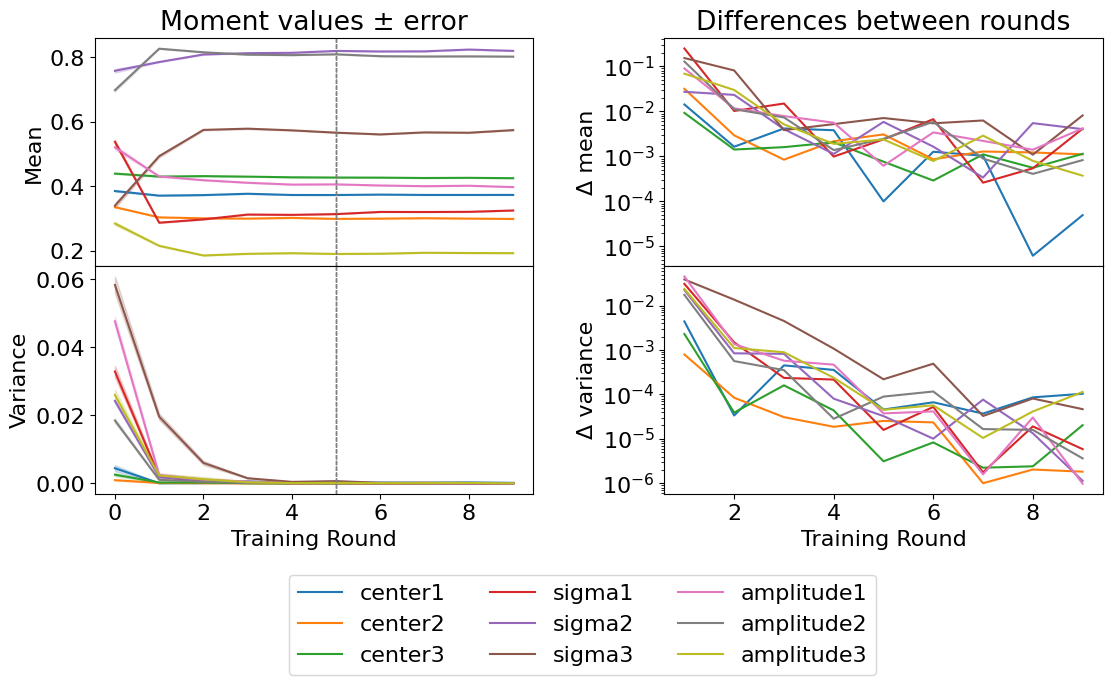

In [ ]:
plot_moment_evolution(R[0].proposals[:], 5, compute_moments, R=R[0], num_repeats=10, sample_size=1000)